In [5]:
from radar import *
from rain import Rain

%matplotlib inline

In [6]:
TOP50 = pd.read_csv('../../Paper/TOP50_Events/TOP50_events_Charlotte.csv', parse_dates=[0,1])
TOP50.head()

,t_begin,t_end,24h_total,convective_area
0,2006-08-30 12:00:00,2006-08-31 12:00:00,50.874,43825
1,2006-06-23 12:00:00,2006-06-24 12:00:00,36.337,28241
2,2003-07-12 12:00:00,2003-07-13 12:00:00,31.595,28847
3,2010-05-16 12:00:00,2010-05-17 12:00:00,34.412,21218
4,2010-08-05 12:00:00,2010-08-06 12:00:00,29.636,25176


In [141]:
c = Radar('Charlotte', t=pd.Timestamp('2006-06-23 19:00:00'))

new instance of City object for: CHARLOTTE


In [225]:
c.time.get_loc('2006-06-24 04:00:00')

2224

In [227]:
ixt = c.time.get_loc('2006-06-23 18:00:00')
print ixt

2184


In [209]:
from rpy2 import robjects 
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
SpatialVx = importr('SpatialVx')
rsummary = robjects.r.summary

In [482]:
d={}
for i in range(2184,2224):
    hold = SpatialVx.make_SpatialVx(c.box[i,:,:], c.box[i+1,:,:])
    look = SpatialVx.FeatureFinder(hold, smoothpar=2, thresh=10, min_size=20)
    
    try:
        x = rsummary(look, silent=True)[0]
    except:
        continue
    p = pandas2ri.ri2py(x)
    df0 = pd.DataFrame(p, columns=['centroidX', 'centroidY', 'area', 'OrientationAngle', 
                                  'AspectRatio', 'Intensity0.25', 'Intensity0.9'])
    df0['Observed'] = list(df0.index+1)
    m = SpatialVx.centmatch(look, criteria=3, const=15)
    p = pandas2ri.ri2py(m[12])
    df1 = pd.DataFrame(p, columns=['Forecast', 'Observed'])
    l = SpatialVx.FeatureMatchAnalyzer(m)
    try:
        p = pandas2ri.ri2py(rsummary(l, silent=True))
    except:
        continue
    df2 = pd.DataFrame(p, columns=['Partial Hausdorff Distance','Mean Error Distance','Mean Square Error Distance',
                                  'Pratts Figure of Merit','Minimum Separation Distance', 'Centroid Distance',
                                  'Angle Difference','Area Ratio','Intersection Area','Bearing', 'Baddeleys Delta Metric',
                                  'Hausdorff Distance'])
    df3 = df1.join(df2)
    
    d.update({c.time[i]: pd.merge(df0, df3, how='outer')})
    
for k, v in d.items():
    v['lat']=np.nan
    v['lon']=np.nan
    for i in v.index:
        idX = int(np.round(v.centroidX[i]))
        idY = int(np.round(v.centroidY[i]))
        v.set_value(i, 'lat', c.lat[idX, idY])
        v.set_value(i, 'lon', c.lon[idX, idY])
p = pd.Panel(d)

[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
2006-06-24 01:45:00
2006-06-23 21:00:00
2006-06-24 02:00:00
2006-06-24 01:30:00
2006-06-23 23:30:00
2006-06-23 21:15:00
2006-06-23 21:30:00
2006-06-23 21:45:00
2006-06-23 20:45:00
2006-06-24 01:15:00
2006-06-23 22:30:00
2006-06-23 20:30:00
2006-06-23 22:45:00
2006-06-24 01:00:00
2006-06-23 22:00:00
2006-06-24 00:00:00
2006-06-23 23:45:00
2006-06-23 19:00:00
2006-06-23 22:15:00
2006-06-23 19:45:00
2006-06-23 19:15:00
2006-06-23 19:30:00
2006-06-24 00:15:00
2006-06-24 00:30:00
2006-06-24 00:45:00


In [129]:
path = '../../data/CHARLOTTE/Version2/'
t=TOP50.iloc[1,0]
rg = Rain(path=path, name='Charlotte_CRN_gage_{YEAR}.csv', year=t.year, ngages=71, freq='15min')
rg.ll_file = 'Charlotte_CRN_lat_lon.csv'
rg.get_ll(cols=['lat','lon'])

Check the following attributes carefully:
 
save_path = 
per_hour = 4
year = 2006
units = mm
path = ../../data/CHARLOTTE/Version2/
freq = 15min
ngages = 71
name = Charlotte_CRN_gage_2006.csv


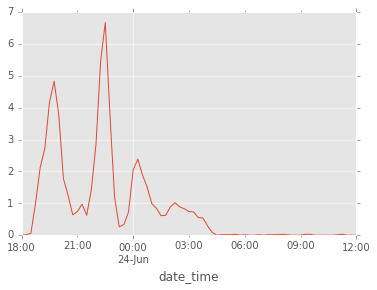

In [483]:
rg.rate['2006-06-23 18':TOP50.iloc[1,1]].mean(axis=1).plot()

In [459]:
c.t = c.time[ixt]

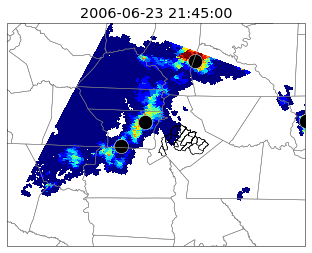

In [469]:
c.t = c.time[ixt+15]
radar_map(c, feat=True)

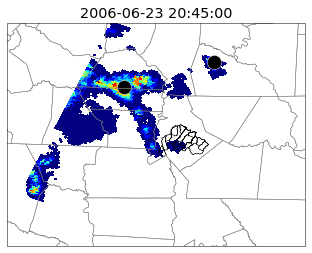

In [465]:
c.t = c.time[ixt+11]
radar_map(c, feat=True)

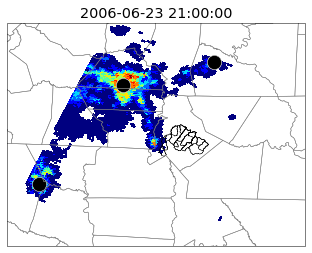

In [466]:
c.t = c.time[ixt+12]
radar_map(c, feat=True)

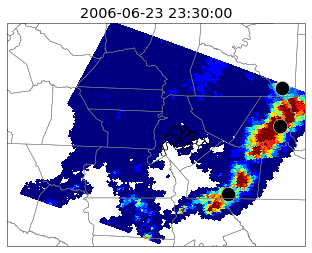

In [452]:
c.t = pd.Timestamp('2006-06-23 23:30:00')
radar_map(c)

In [467]:
%matplotlib inline
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import pandas as pd 
import numpy as np

fname = '../../data/CHARLOTTE/Maps/new_basin.shp'
basins = list(shpreader.Reader(fname).geometries())

fname = '../../data/CHARLOTTE/Maps/county.shp'
county = list(shpreader.Reader(fname).geometries())

cmap = plt.cm.get_cmap('jet', 10)
cmap.set_under(color='None')

def radar_map(radar, feat=False, save=False):
    ax = plt.axes(projection=ccrs.PlateCarree())

    plt.title(radar.t)
    i = radar.time.get_loc(radar.t)
    ax.add_geometries(basins, ccrs.PlateCarree(), edgecolor='black', facecolor='None')
    ax.add_geometries(county, ccrs.PlateCarree(), edgecolor='gray', facecolor='None')
    ax.set_extent([-82, -80, 34.5, 36], ccrs.PlateCarree())
    ax.pcolor(radar.lon, radar.lat, radar.box[i,:,:], vmin=.1, vmax=25, cmap=cmap);
    if feat:
        try:
            ax.scatter(p[radar.t].lon, p[radar.t].lat, c='black',s=200)
        except:
            print 'no features found'
            pass
    if save:
        plt.savefig('output/{t}.png'.format(t=radar.t))